In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from textwrap import fill
from synergy_dataset import Dataset, iter_datasets
from buscarpy import calculate_h0
from fastlite import *
from fastcore.utils import *
from fastcore.net import urlsave
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

In [2]:
%%sh
bash sync.sh

In [3]:
dbpath = 'output_data/experiments.sql'
con = sqlite3.connect(dbpath)
rdf = pd.read_sql_query('SELECT * FROM reviews',con)
rdf

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


In [4]:
d_map = {}
max_len = 10
for d in iter_datasets():
    ti = d.metadata['publication']['title']
    d_map[d.name] = fill(ti, width=80)
d_map

{'Appenzeller-Herzog_2019': 'Comparative effectiveness of common therapies for Wilson disease: A systematic\nreview and meta‐analysis of controlled studies',
 'Bos_2018': 'Cerebral small vessel disease and the risk of dementia: A systematic review and\nmeta‐analysis of population‐based evidence',
 'Brouwer_2019': 'Psychological theories of depressive relapse and recurrence: A systematic review\nand meta-analysis of prospective studies',
 'Chou_2003': 'Comparative efficacy and safety of long-acting oral opioids for chronic non-\ncancer pain: a systematic review',
 'Chou_2004': 'Comparative efficacy and safety of skeletal muscle relaxants for spasticity and\nmusculoskeletal conditions: a systematic review',
 'Donners_2021': 'Pharmacokinetics and Associated Efficacy of Emicizumab in Humans: A Systematic\nReview',
 'Hall_2012': 'A Systematic Literature Review on Fault Prediction Performance in Software\nEngineering',
 'Jeyaraman_2020': 'Does the Source of Mesenchymal Stem Cell Have an Effe

In [5]:
def proc_llm_df(llm_df):
    llm_df['pred'] = llm_df['py'] - llm_df['pn']    
    llm_df['pmass'] = llm_df['py'] + llm_df['pn']
    llm_df['alt_pred'] = llm_df['pred'] * llm_df['pmass']
    # Sort LLM results in descending order of pred, the order we would screen them
    llm_df = llm_df.sort_values('pred', ascending=False)
    # Calculate recall, the order, and x, the proportion of documents screened
    
    llm_df['recall'] = llm_df['y'].cumsum() / llm_df['y'].sum()
    llm_df['order'] = np.arange(llm_df.shape[0])
    llm_df['x'] = llm_df['order'] / llm_df.shape[0] 
    return llm_df

In [6]:
models = [
    "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-2-7b-chat-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    # "meta-llama/Llama-2-13b-chat",
    # "meta-llama/Llama-2-70b-chat"
]

In [7]:
rdf

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


In [8]:
pq.read_table(
    f'output_data/llm_preds'
)['model'].unique().dictionary.to_pylist()

['meta-llama/Llama-2-70b-chat-hf',
 'meta-llama/Llama-2-7b-chat-hf',
 'meta-llama/Meta-Llama-3.1-70B-Instruct',
 'meta-llama/Meta-Llama-3.1-8B-Instruct']

In [9]:
rdf.shape[0]
import itertools
combinations = list(itertools.product(rdf.review_name, models))
len(combinations)

104

In [10]:
rank = 2
runs = [x for i,x in enumerate(combinations) if i%100==rank]
runs

[('Appenzeller-Herzog_2019', 'meta-llama/Llama-2-7b-chat-hf'),
 ('Wolters_2018', 'meta-llama/Llama-2-7b-chat-hf')]

In [11]:
for review_id, model in runs:
    print(review_id)
    print(model)

Appenzeller-Herzog_2019
meta-llama/Llama-2-7b-chat-hf
Wolters_2018
meta-llama/Llama-2-7b-chat-hf


In [12]:
model = models[1]
review_name = 'Appenzeller-Herzog_2019'
llm_df = pq.read_table(
    f'output_data/llm_preds',
    filters=[
        ('review', '=', review_name),
        ('model', '=', model)
    ]
).to_pandas().dropna()
llm_df

,y,py,pn,pred,screened_order,p_0.8,p_0.9,p_0.95,p_0.99,review,model
openalex_id,,,,,,,,,,,
https://openalex.org/W2607657572,0,0.975867,0.011476,0.964391,10,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2093266833,0,0.976630,0.013116,0.963513,11,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2023411819,0,0.976416,0.014902,0.961514,12,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W854776818,0,0.974803,0.013418,0.961385,13,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2091516044,0,0.975182,0.013807,0.961375,14,0.998955,0.998955,0.998955,0.998955,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
...,...,...,...,...,...,...,...,...,...,...,...
https://openalex.org/W2426015457,0,-0.985729,0.989770,-1.975499,5741,0.009972,0.009402,0.009816,0.011364,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2543895988,0,-0.985663,0.992319,-1.977982,5742,0.009972,0.009402,0.009816,0.011364,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W4249121410,0,-0.987634,0.991103,-1.978737,5743,0.009972,0.009402,0.009816,0.011364,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct


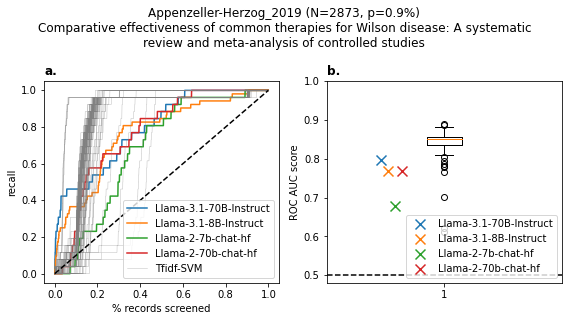

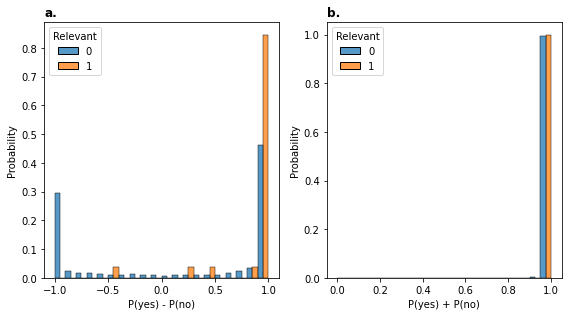

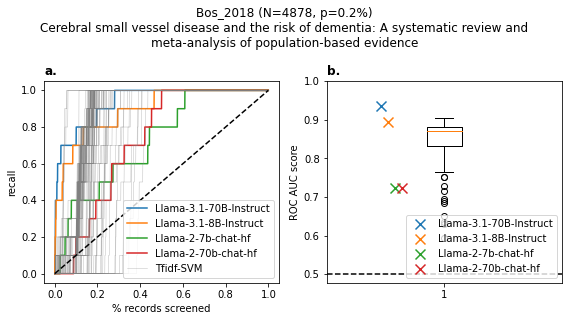

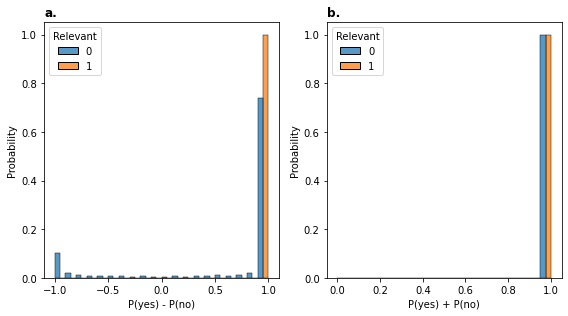

/tmp/ipykernel_9923/4015576800.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_9923/4015576800.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/tmp/ipykernel_9923/4015576800.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


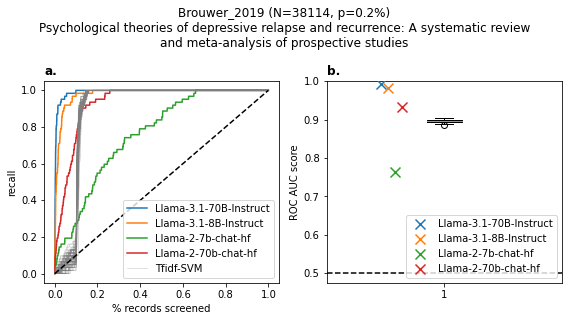

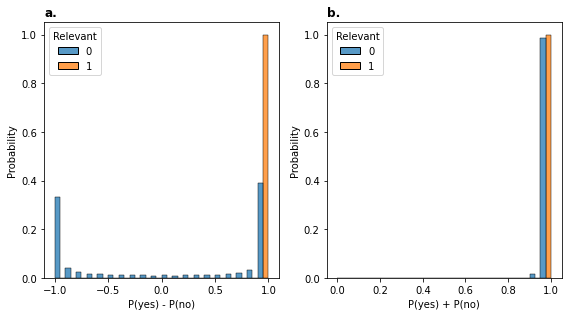

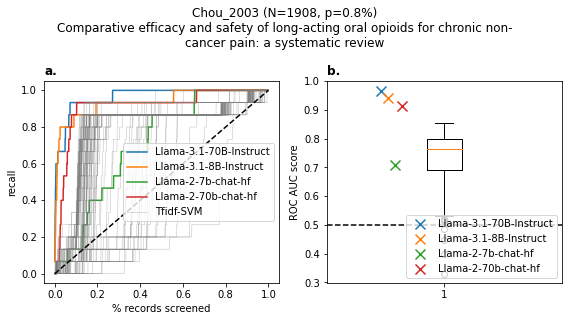

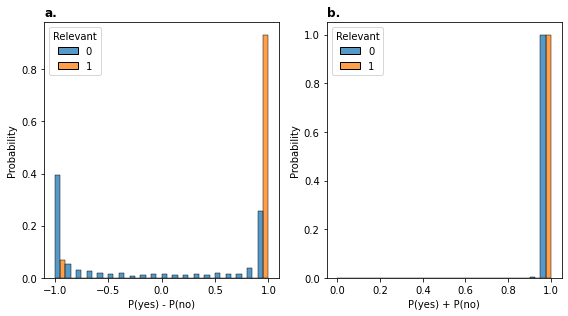

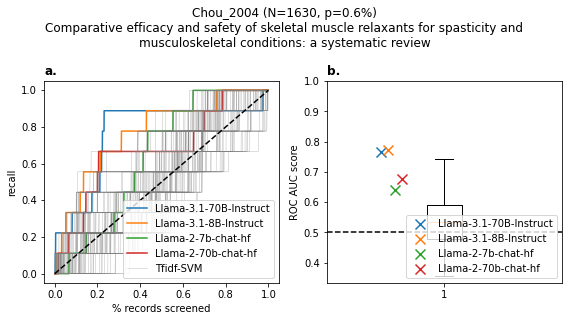

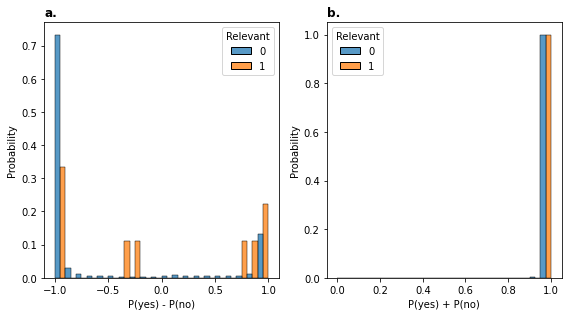

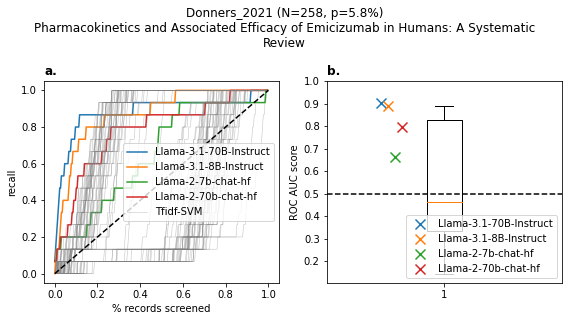

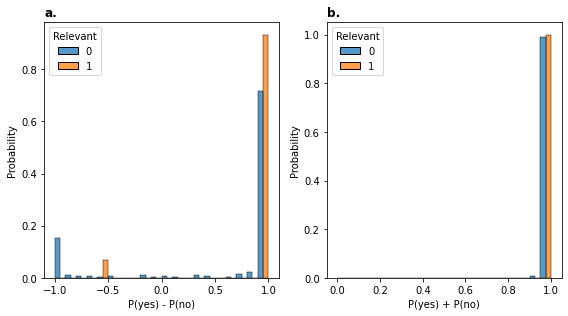

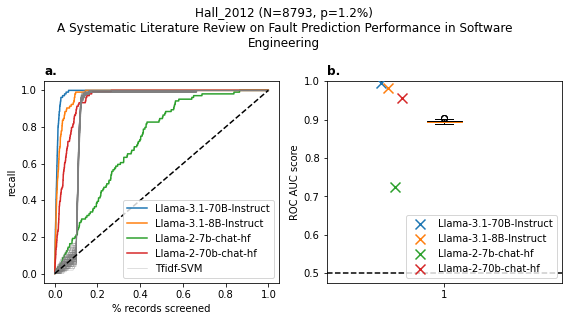

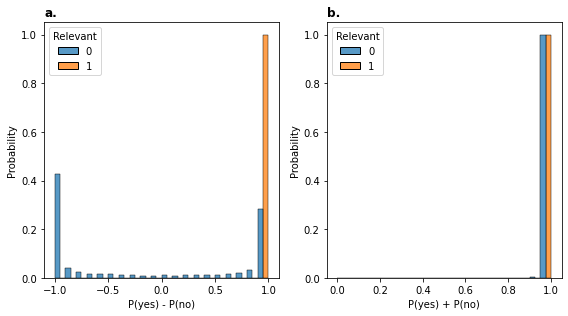

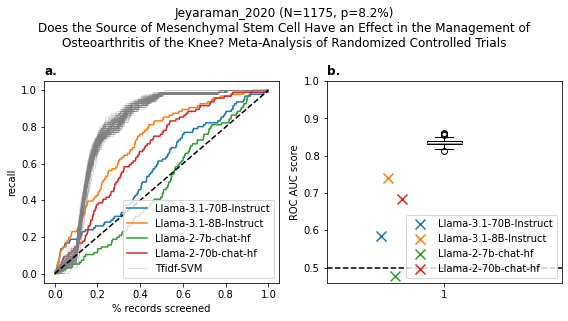

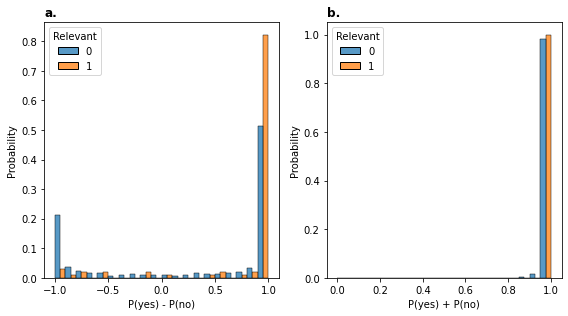

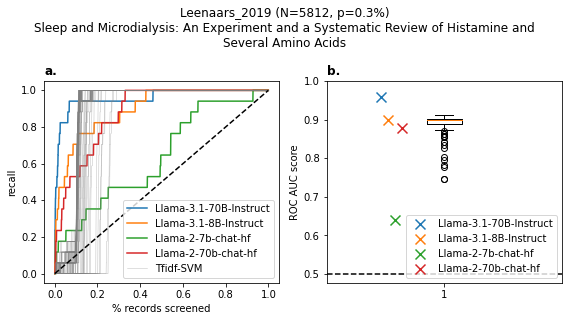

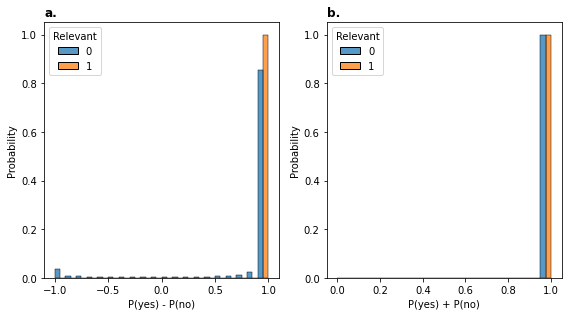

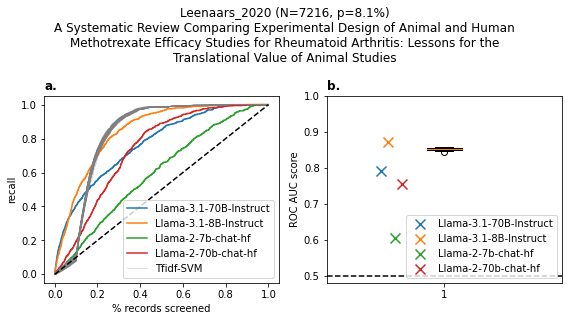

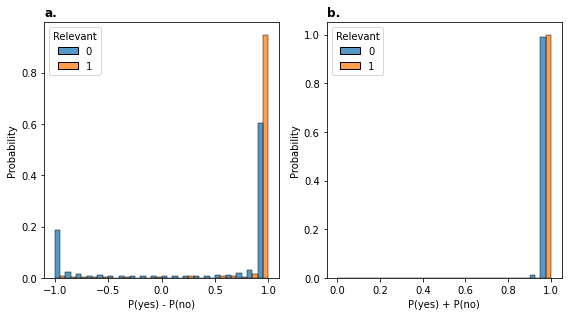

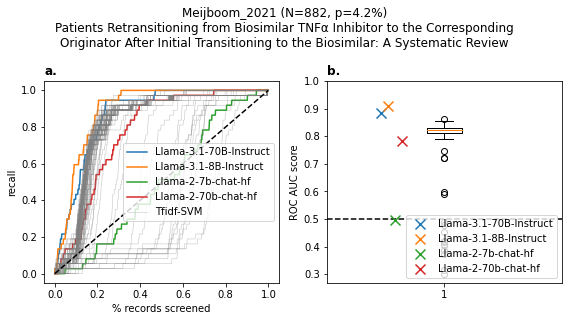

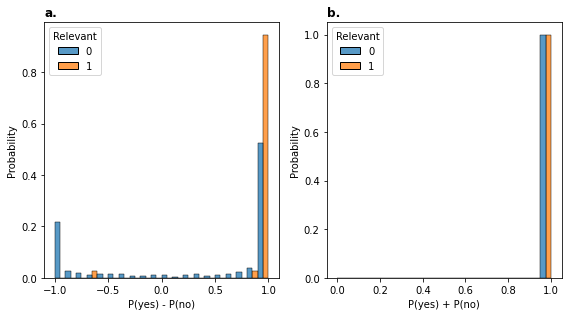

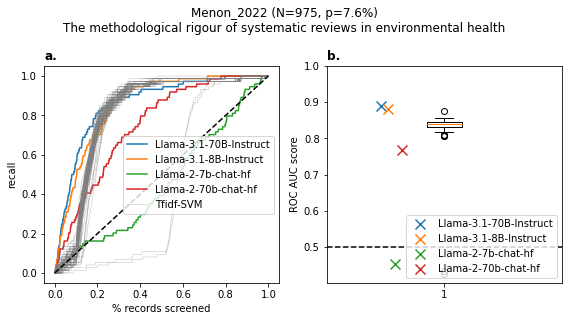

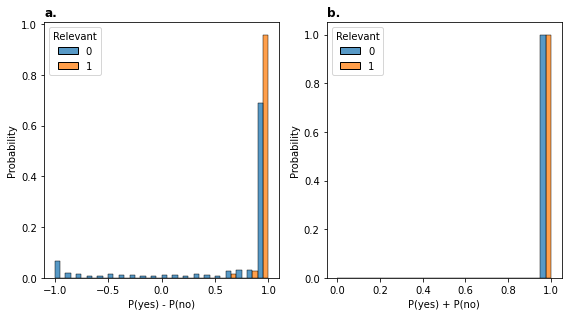

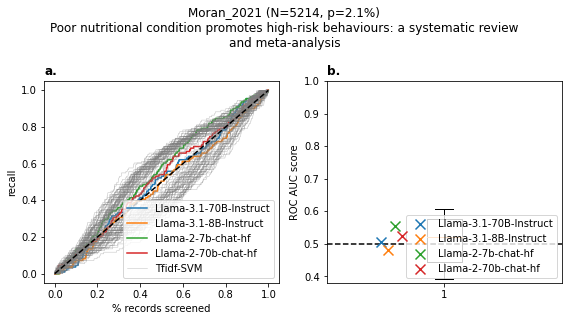

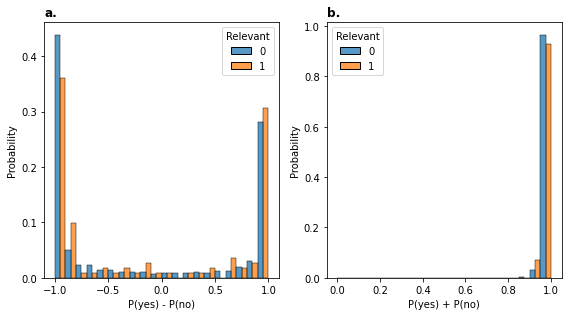

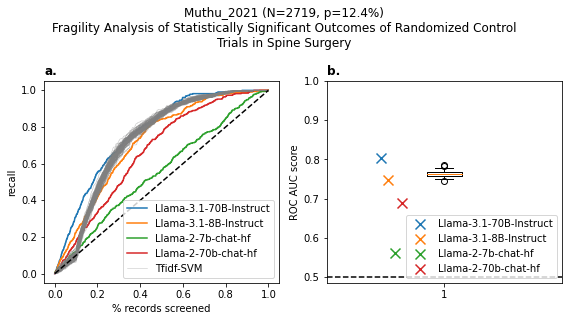

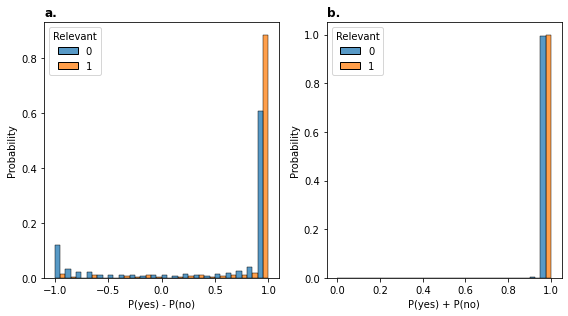

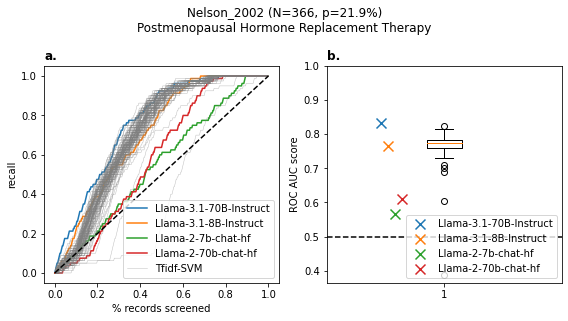

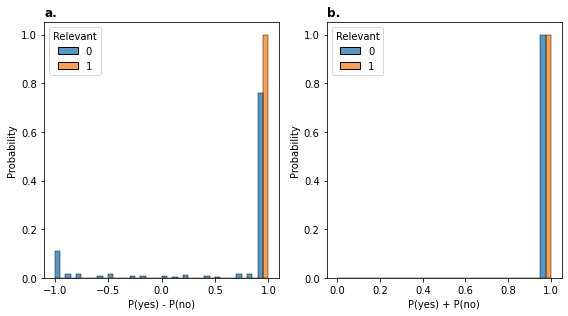

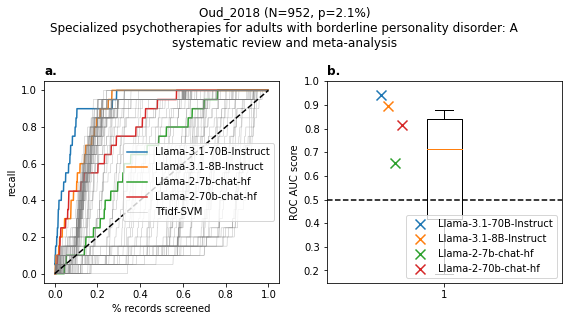

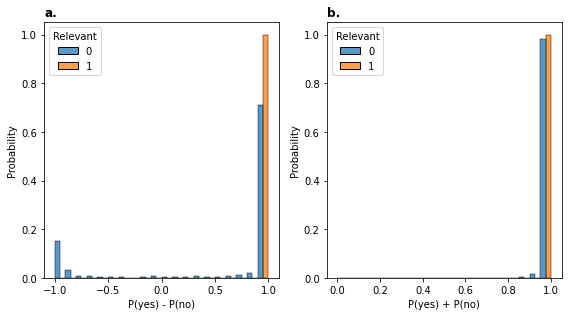

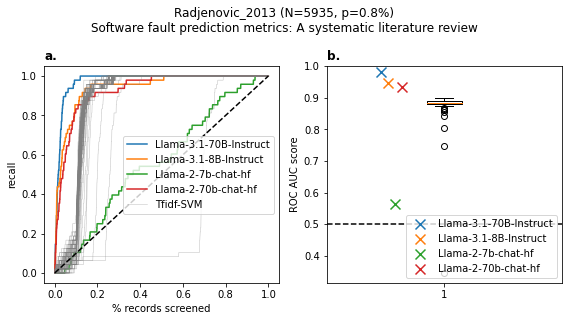

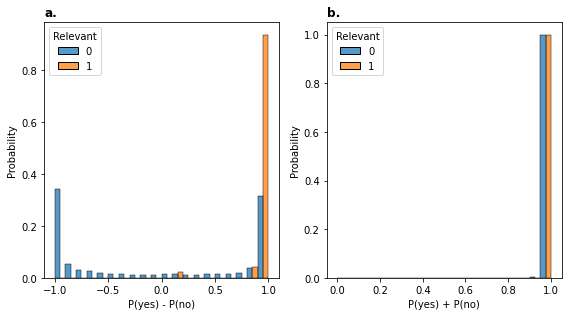

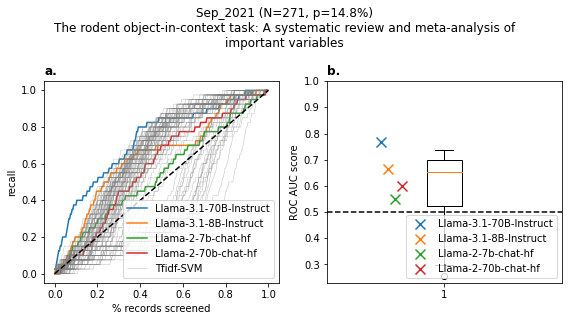

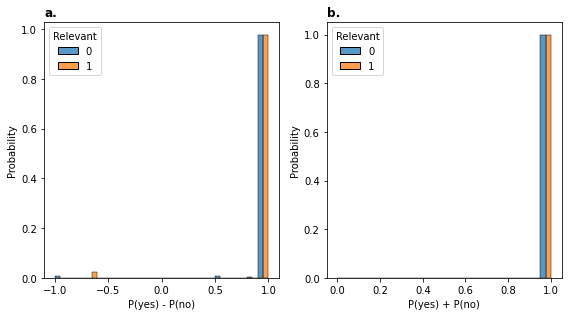

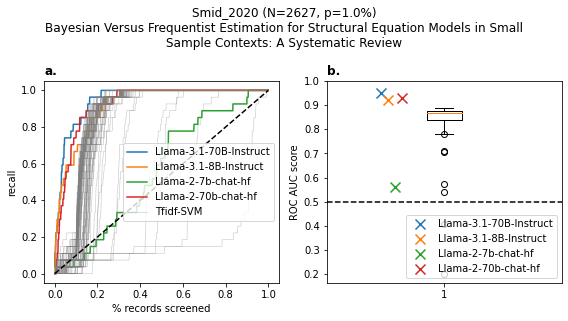

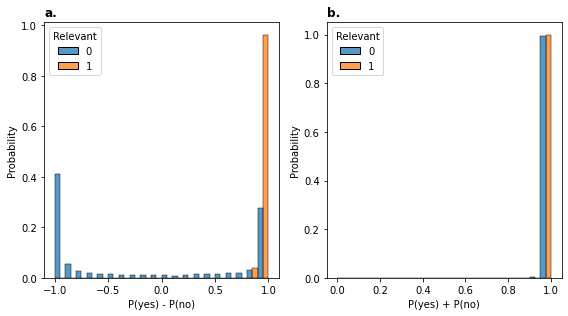

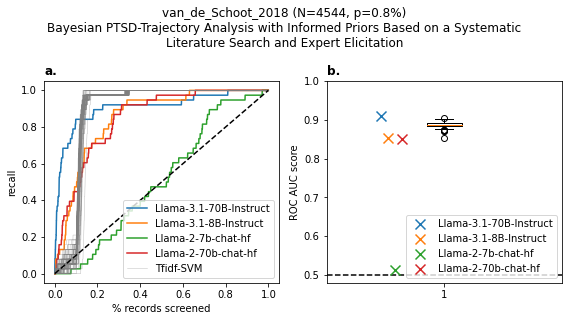

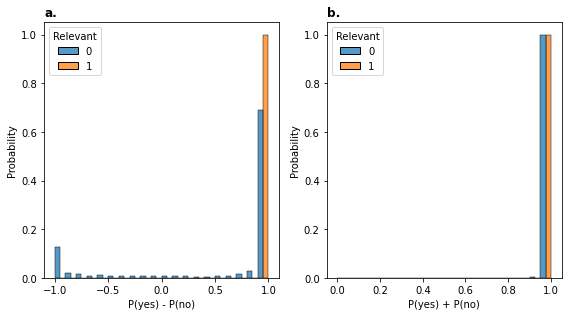

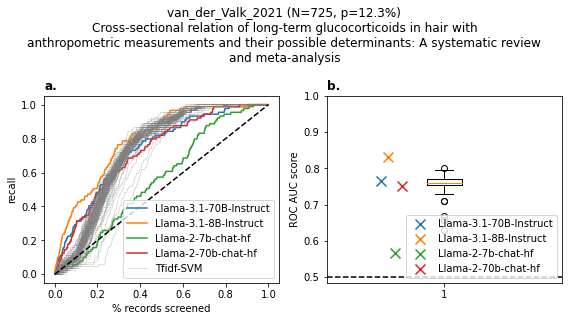

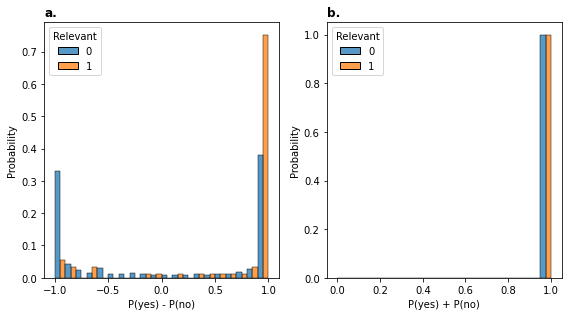

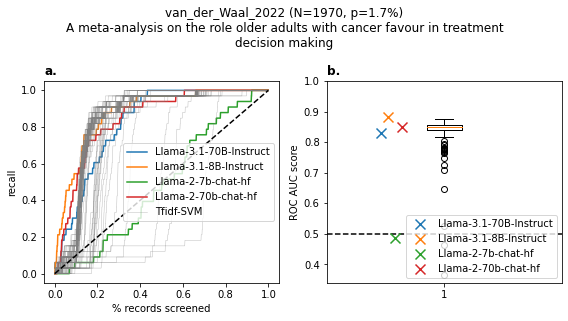

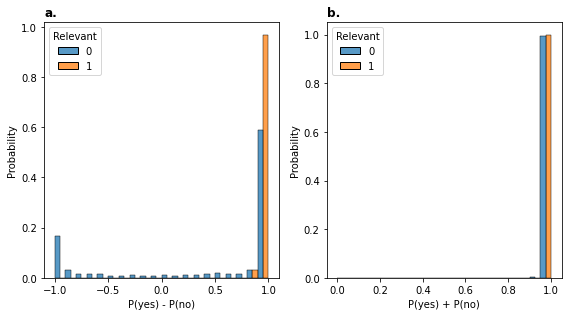

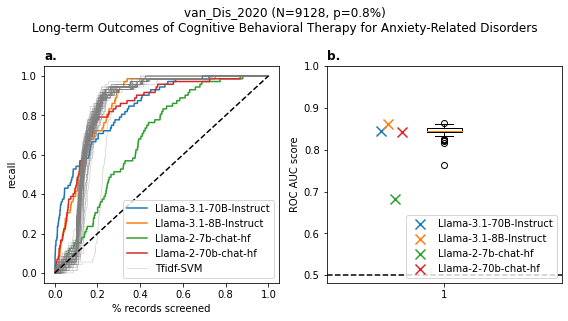

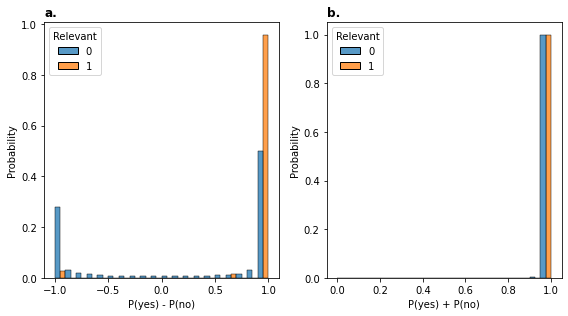

/tmp/ipykernel_9923/4015576800.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_9923/4015576800.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/tmp/ipykernel_9923/4015576800.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


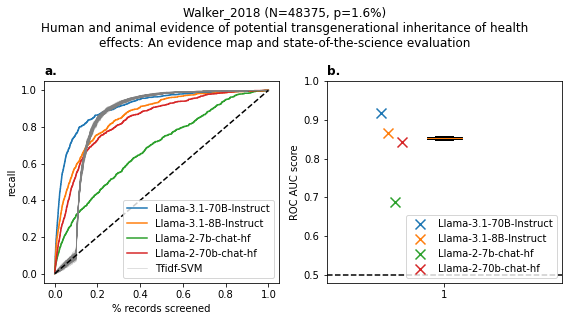

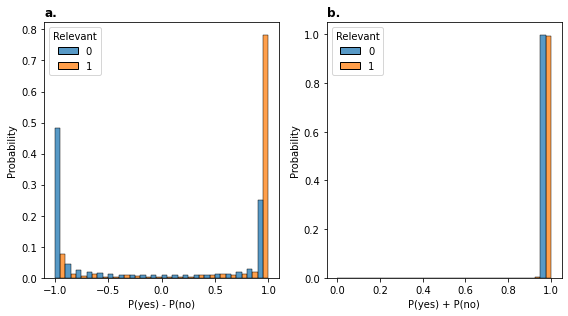

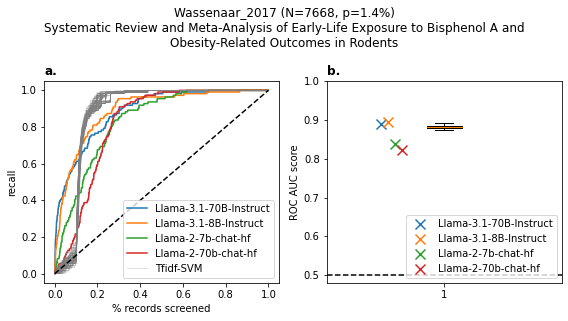

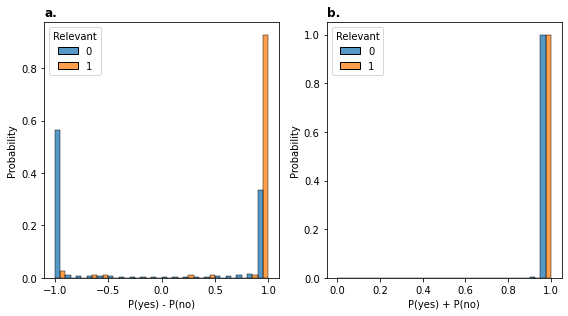

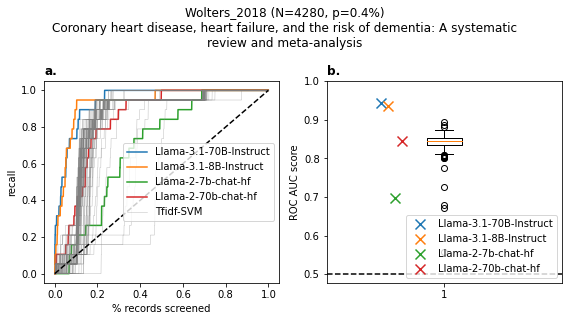

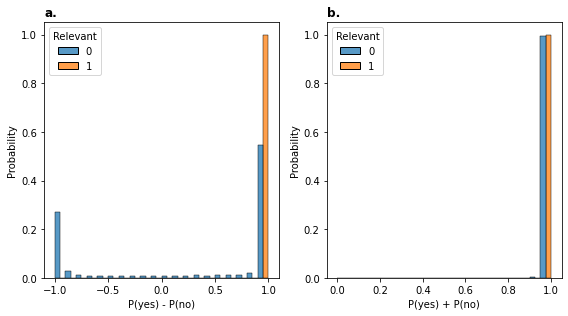

In [13]:
svm_auc_scores = []
llm_auc_scores = []
stopping_points = []

reviews = []


def order_score(x):
    return 1-(x-x.min())/(x.max()-x.min())

for r, row in rdf.iterrows():
    review_name = row['review_name']
    table = pq.read_table(
        'output_data/ordered_records', 
        filters=[('review_id', '=', row['review_id'])]
    )
    
    # Setup graph with two panels
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))
    axs[0].set_title('a.', loc='left', fontweight='bold')
    axs[1].set_title('b.', loc='left', fontweight='bold')
    ax = axs[0]
    
    llm_aucs = []
    for model in models:
        llm_res = pq.read_table(
            f'output_data/llm_preds',
            filters=[
                ('review', '=', review_name),
                ('model', '=', model)
            ]
        ).to_pandas()#.dropna()

        if llm_res.shape[0] == 0:
            llm_aucs.append(None)
            continue

        llm_df = proc_llm_df(llm_res)

        # Plot LLM recall curve
        ax.plot(llm_df['x'], llm_df['recall'], label=model.split('/')[1].replace('Meta-',''))
        # Calculate LLM ROC AUC score and plot it with an x
        auc = roc_auc_score(llm_df['y'], llm_df['pred'])
        llm_aucs.append(auc)
        
        # record stopping citeria
        for r in [0.8,0.9,0.95,0.99]:
            for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
                s_point = llm_df.loc[llm_df[f'p_{r}']<1-c,]
                sres = {
                    'recall_target': r,
                    'confidence': c,
                    'model': model,
                    'run_id': 0,
                    'review_name': review_name
                }
                if s_point.shape[0]==0:
                    s_point = llm_df.tail(1)
                sres[f'recall'] = s_point['recall'].values[0]
                sres[f'wss'] = llm_df.shape[0] - s_point['order'].values[0]
                sres['wss_p'] = sres['wss'] / llm_df.shape[0]
                stopping_points.append(sres)
        
    llm_auc_scores.append(llm_aucs)
            
    if llm_df.shape[0]==0:
        continue
        
    

    study_title = f'{review_name} (N={llm_df.shape[0]}, p={llm_df["y"].sum()/llm_df.shape[0]:.1%})'
    reviews.append(study_title)
    plt.suptitle(study_title + '\n' + d_map[review_name])

    #  Go through each active learning run, and plot progress
    aucs = []

    for i, (name, group) in enumerate(table.to_pandas().groupby('run_id', observed=False)):
        group = group.sort_values('screened_order').reset_index()
        group['score'] = order_score(group['screened_order'])
        group['x'] = group['screened_order'] / group.shape[0]
        group['recall'] = group['relevant'].cumsum()/group['relevant'].sum()
        aucs.append(roc_auc_score(group['relevant'],group['score']))
        ax.plot(group['x'], group['recall'], color='grey',alpha=0.5,lw=0.5, label='Tfidf-SVM' if i==0 else None)
        
        # record stopping points
        for r in [0.8,0.9,0.95,0.99]:
            for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
                sres = {
                    'recall_target': r,
                    'confidence': c,
                    'run_id': name,
                    'model': 'SVM',
                    'review_name': review_name
                }
                s_point = group.loc[group[f'p_{r}']<1-c,]
                if s_point.shape[0]==0:
                    s_point = group.tail(1)
                sres[f'recall'] = s_point['recall'].values[0]
                sres[f'wss'] = group.shape[0] - s_point['screened_order'].values[0]
                sres['wss_p'] = sres['wss'] / group.shape[0]
                stopping_points.append(sres)
    svm_auc_scores.append(aucs)

    # Plot a diagonal line showing random chance
    ax.plot([0,1],[0,1], color='black',ls='--')

    ax.legend()

    # Show the distribution of ROC AUC scores
    axs[1].boxplot(aucs)
    axs[1].axhline(0.5, color='black', ls='--')
    
    j = 0
    for m, s in zip(models, llm_aucs):
        j+=1
        axs[1].scatter(
            0.7+j*0.03, s,     
            marker='x',
            s=100,
            zorder=50,
            label=m.split('/')[1].replace('Meta-','')
        )

    # Legend and axis labels
    axs[1].legend(loc='lower right')
    axs[0].set_xlabel('% records screened')
    axs[0].set_ylabel('recall')
    axs[1].set_ylim(ymax=1)
    axs[1].set_ylabel('ROC AUC score')
    plt.tight_layout()
    plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
    plt.show()

    # New plot for distribution of p scores
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))

    # Distribution of p(Yes)-P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pred', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[0],
        binwidth=0.1, binrange=[-1,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[0].set_xlabel('P(yes) - P(no)')

    # Distribution of p(Yes)+P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pmass', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[1],
        binwidth=0.05, binrange=[0,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[1].set_xlabel('P(yes) + P(no)')
    #plt.suptitle(study_title + '\n' + d_map[review])
    
    axs[0].set_title('a.', loc='left', fontweight='bold')
    axs[1].set_title('b.', loc='left', fontweight='bold')

    fig.tight_layout()
    plt.savefig(f'figures/{review_name}_p_distribution.pdf', bbox_inches='tight')
    plt.show()

In [14]:
# table = pq.read_table(
#     'output_data/ordered_records', 
#     filters=[
#         ('review_id', '=', 1),
#         ('run_id','=',1)
#     ]
# ).to_pandas().sort_values('screened_order').reset_index(drop=True)
# batch_size = 1000
# for recall_target in [0.8,0.9,0.95,0.99]:
#     pdf = pd.DataFrame(
#         retrospective_h0(
#             table['relevant'], table.shape[0], 
#             batch_size=batch_size, plot=False, recall_target=recall_target,
#             confidence_level=0.99
#         )
#     ).rename(columns={'p': f'p_{recall_target}'})
#     table = table.merge(
#         pdf, left_on='screened_order', right_on='batch_sizes', how='left'
#     ).drop(columns='batch_sizes').ffill()
# table

In [15]:
sdf = pd.DataFrame.from_dict(stopping_points).merge(rdf[['review_name','n_records','prevalence']])
sdf

,recall_target,confidence,model,run_id,review_name,recall,wss,wss_p,n_records,prevalence
0,0.80,0.50,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Appenzeller-Herzog_2019,0.923077,1243.0,0.432649,2873,0.009050
1,0.80,0.66,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Appenzeller-Herzog_2019,1.000000,963.0,0.335190,2873,0.009050
2,0.80,0.80,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Appenzeller-Herzog_2019,1.000000,893.0,0.310825,2873,0.009050
3,0.80,0.90,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Appenzeller-Herzog_2019,1.000000,803.0,0.279499,2873,0.009050
4,0.80,0.95,meta-llama/Meta-Llama-3.1-70B-Instruct,0,Appenzeller-Herzog_2019,1.000000,733.0,0.255134,2873,0.009050
...,...,...,...,...,...,...,...,...,...,...
64891,0.99,0.66,SVM,99,Wolters_2018,1.000000,630.0,0.147196,4280,0.004439
64892,0.99,0.80,SVM,99,Wolters_2018,1.000000,350.0,0.081776,4280,0.004439
64893,0.99,0.90,SVM,99,Wolters_2018,1.000000,170.0,0.039720,4280,0.004439
64894,0.99,0.95,SVM,99,Wolters_2018,1.000000,80.0,0.018692,4280,0.004439


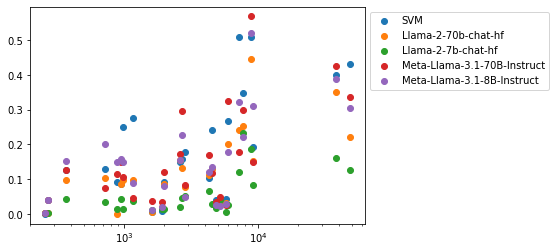

In [16]:
fig, ax = plt.subplots()

sdf_rc = sdf[(sdf['recall_target']==0.95) & (sdf['confidence']==0.95)]

for name, group in sdf_rc.groupby('model'):
    group = group[['n_records','wss_p','review_name']].groupby('review_name').median()
    ax.scatter(group['n_records'], group['wss_p'], label=name.split('/')[-1])
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1,1))

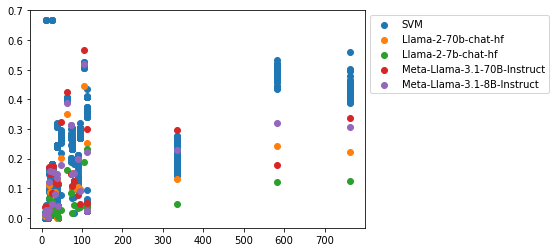

In [17]:
fig, ax = plt.subplots()
for name, group in sdf_rc.groupby('model'):
    ax.scatter(group['n_records']*group['prevalence'], group['wss_p'], label=name.split('/')[-1])
    
ax.legend(bbox_to_anchor=(1,1))
#ax.set_xscale('log')

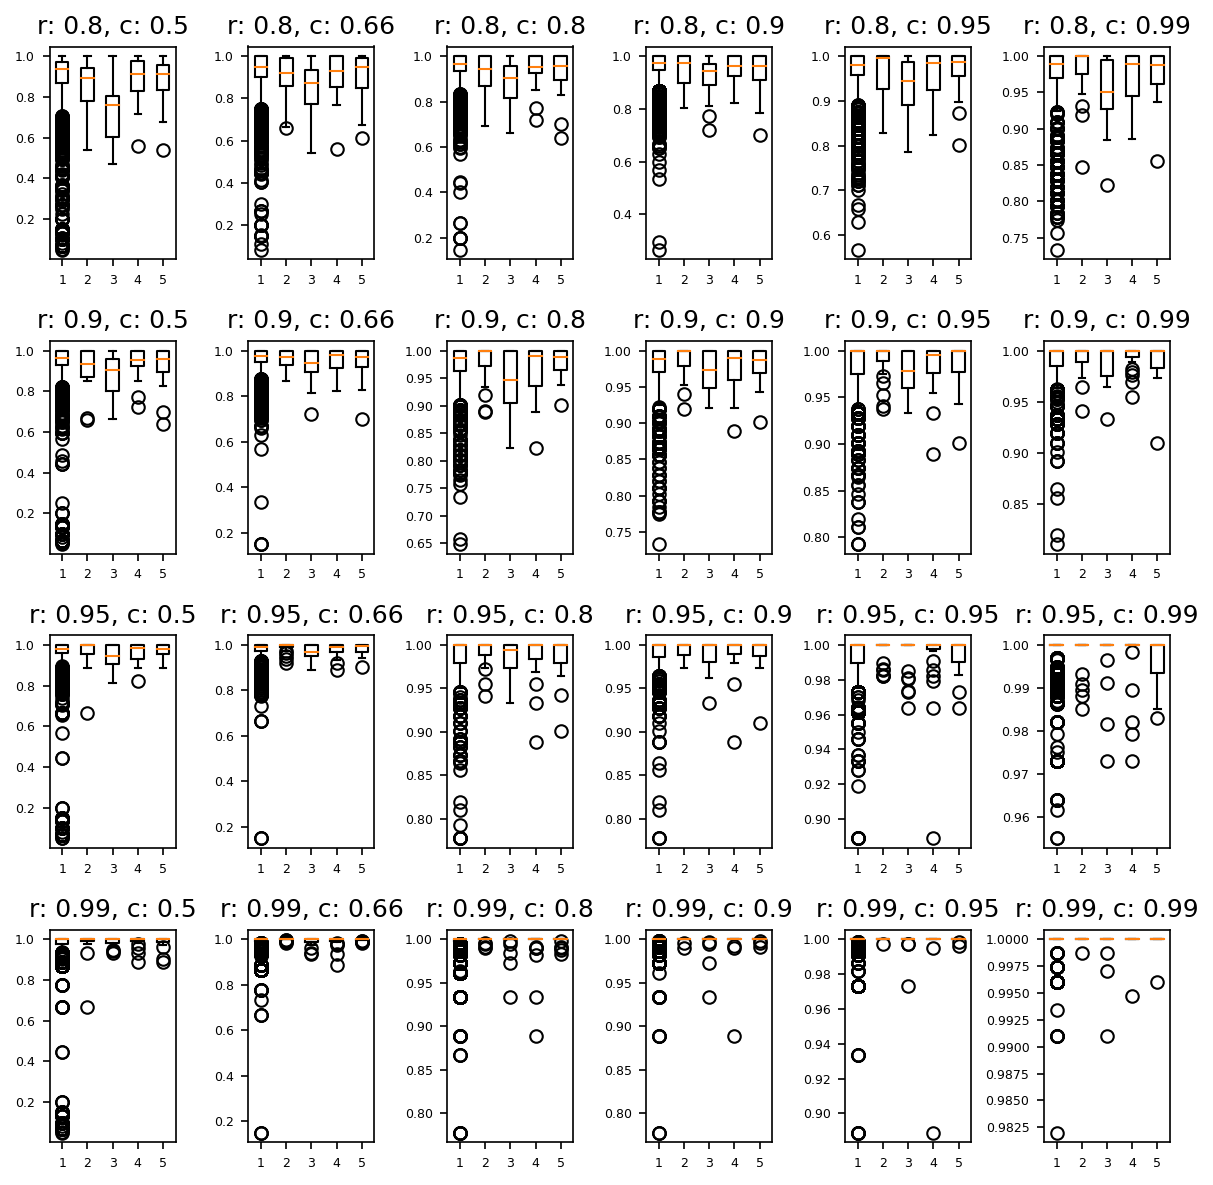

In [18]:
recall_levels = [0.8,0.9,0.95,0.99]
conf_levels = [0.5,0.66,0.8,0.9,0.95,0.99]



fig, axs = plt.subplots(len(recall_levels), len(conf_levels), figsize=(8,8), dpi=150)

for i, r in enumerate(recall_levels):
    for j, c in enumerate(conf_levels):
        ax = axs[i,j]
        ax.set_title(f'r: {r}, c: {c}')
        group = sdf[
            (sdf['recall_target']==r) &
            (sdf['confidence']==c)
        ]
        data, names = zip(*[(g['recall'], name) for name, g in group.groupby('model')])
        ax.boxplot(data)
        ax.tick_params(labelsize=6)
        
fig.tight_layout()

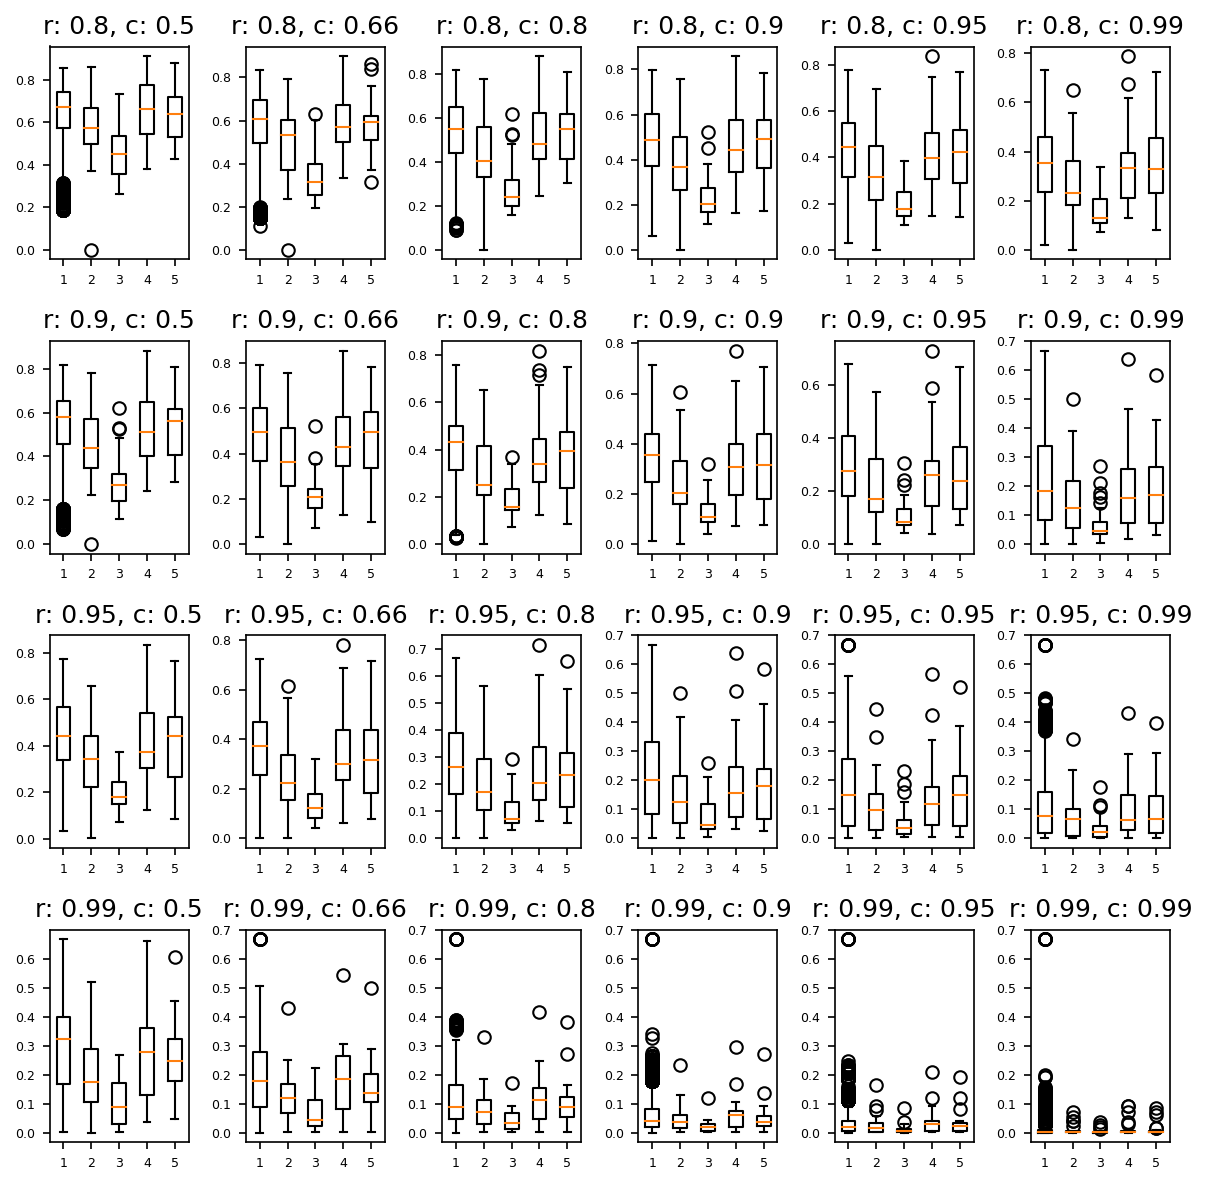

In [19]:
recall_levels = [0.8,0.9,0.95,0.99]
conf_levels = [0.5,0.66,0.8,0.9,0.95,0.99]

fig, axs = plt.subplots(len(recall_levels), len(conf_levels), figsize=(8,8), dpi=150)

for i, r in enumerate(recall_levels):
    for j, c in enumerate(conf_levels):
        ax = axs[i,j]
        ax.set_title(f'r: {r}, c: {c}')
        group = sdf[
            (sdf['recall_target']==r) &
            (sdf['confidence']==c)
        ]
        data, names = zip(*[(g['wss_p'], name) for name, g in group.groupby('model')])
        ax.boxplot(data)
        ax.tick_params(labelsize=6)
        
fig.tight_layout()

In [20]:
def clean_model_title(x):
    x = x.split('/')[-1]
    x = x.replace('Meta-','')
    x = x.replace('-Instruct','')
    x = x.replace('-chat-hf','')
    return x
models_short = [clean_model_title(x) for x in models]
models_short

['Llama-3.1-70B', 'Llama-3.1-8B', 'Llama-2-7b', 'Llama-2-70b']

In [21]:
col_order = [
    'SVM',
    'Llama-2-7b',
    'Llama-2-70b',
    'Llama-3.1-8B',
    'Llama-3.1-70B',
]

In [50]:
rdf['n_records'].sum()

169288

In [54]:
rdf['n_records'].min()


258

In [55]:
rdf['n_records'].max()

48375

In [67]:
7980/rdf['n_records'].sum()

0.0471386040357261

In [66]:

def sum_f(x):
    return sum


sdf['model'] = sdf['model'].apply(lambda x: clean_model_title(x))
tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])].groupby(
    ['model','review_name','recall_target','confidence']
)['wss'].median().reset_index().rename(columns={'recall_target':'r target','confidence': 'confidence'}).pivot_table(
    index=['r target','confidence'],
    columns=['model'],
    values='wss',
    aggfunc=sum
).astype(int)#.reset_index()
tab
#tab.columns.name = None
# cols = [
#     'recall_target',
#     'confidence',
#     '
# tab = tab[['recall_
models_short = [clean_model_title(x) for x in models]

vis = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='font-weight:bold;',
    #props='color:red',
    axis=1
).format(
    '{:,.0f}', subset = ['SVM'] + models_short
).format_index('{:.2f}')
out = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='textbf:--rwrap',
    axis=1,
).format_index('{:.2f}').format('{:,d}')
out.to_latex(
    "tables/wsst.tex",
    hrules=True,
    multirow_align='naive',
    clines='skip-last;data'
)
vis

/tmp/ipykernel_9923/595555419.py:6: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])].groupby(


In [64]:
tab.astype(int)

model                Llama-2-70b  Llama-2-7b  Llama-3.1-70B  Llama-3.1-8B  \
r target confidence                                                         
0.80     0.50             121777      100248         132808        127401   
         0.80              97147       64568         114748        111411   
         0.90              90327       57678         106668        101871   
         0.95              83338       48608         101288         94921   
         0.99              71397       37838          85058         79471   
0.90     0.50              99217       65778         115498        112011   
         0.80              79807       42768          97438         83661   
         0.90              65007       34158          82268         76701   
         0.95              59447       28748          73108         69251   
         0.99              49790       23118          59088         55091   
0.95     0.50              82907       44408         101318         94731   
         0.80              58587       27238          68678         64281   
         0.90              44470       21738          57388         53091   
         0.95              37370       18781          48671         45954   
         0.99              27171       13545          35592         34855   
0.99     0.50              42897       22638          55378         54811   
         0.80              20597       11158          30398         29191   
         0.90              13480        5825          18478         13641   
         0.95               8837        4065          11938          9435   
         0.99               4355        1985           6625          4934   

model                   SVM  
r target confidence          
0.80     0.50        126898  
         0.80        113708  
         0.90        105053  
         0.95         98503  
         0.99         87803  
0.90     0.50        114988  
         0.80         93923  
         0.90         84658  
         0.95         76483  
         0.99         62350  
0.95     0.50         98258  
         0.80         74098  
         0.90         63245  
         0.95         54860  
         0.99         41676  
0.99     0.50         63573  
         0.80         31323  
         0.90         21160  
         0.95         16229  
         0.99          7980

In [47]:
tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])]
s_dist = []

for (r,c,model), group in tab.groupby(['recall_target','confidence','model']):
    m = group['recall'].median()
    p = group['recall'].quantile(1-c)
    s_dist.append({
        'model': model,
        'recall_target': r,
        'confidence': c,
        'recall_m': m,
        'recall_p': p,
        'r': f'{m:.2f} ({p:.2f})'
    })
    
tab = pd.DataFrame.from_dict(s_dist).rename(columns={'recall_target':'r target','confidence': 'confidence'}).pivot(
    index=['r target','confidence'],
    columns=['model'],
    values='recall_p',
)

def toolow(val, style):
    """
    highlight in red if value is below recall target
    """
    test = val<val.name[0]
    return [style if v else '' for v in test]

vis = tab[col_order].style.apply(
    lambda x: toolow(x,'background-color: red'), axis=1,
).format(
    '{:,.3f}', subset = ['SVM'] + models_short
).format_index('{:.2f}')
out = tab[col_order].style.apply(
    lambda x: toolow(x,'textbf:--rwrap'), axis=1,
).format_index('{:.2f}').format('{:,.3f}')
out.to_latex(
    "tables/recall.tex",
    hrules=True,
    multirow_align='naive',
    clines='skip-last;data'
)
vis

In [48]:
def mean_dist(x):
    return f'{np.mean(x):.3f} ({np.std(x):.2f})'

sdf['model'] = sdf['model'].apply(lambda x: clean_model_title(x))
tab = sdf[sdf['confidence'].isin([0.5,0.8,0.9,0.95,0.99])].groupby(
    ['model','review_name','recall_target','confidence']
)['wss_p'].median().reset_index().rename(columns={'recall_target':'r target','confidence': 'confidence'}).pivot_table(
    index=['r target','confidence'],
    columns=['model'],
    values='wss_p',
    aggfunc=mean_dist
)#.reset_index()
#tab.columns.name = None


vis = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='font-weight:bold;',
    axis=1
).format_index('{:.2f}')#.format(
#    '{:.2f}', subset=['recall_target','confidence']
#)
out = tab[col_order].style.highlight_max(
    subset=['SVM'] + models_short,
    props='textbf:--rwrap',
    axis=1,
).format_index('{:.2f}')
out.to_latex(
    "tables/wss_p.tex",
    hrules=True,
    multirow_align='naive',
    clines='skip-last;data'
)
vis

In [80]:
sdf.groupby(
    ['model','review_name','recall_target','confidence']
)['wss'].median().groupby(['model','recall_target','confidence']).count()

model                                  recall_target  confidence
SVM                                    0.80           0.50          1
                                                      0.66          1
                                                      0.80          1
                                                      0.90          1
                                                      0.95          1
                                                                   ..
meta-llama/Meta-Llama-3.1-8B-Instruct  0.99           0.66          1
                                                      0.80          1
                                                      0.90          1
                                                      0.95          1
                                                      0.99          1
Name: wss, Length: 120, dtype: int64

In [81]:
sdf[
    (sdf['recall_target']==0.80) &
    (sdf['confidence']==0.5)
].groupby(
    ['model','review_name','recall_target','confidence']
)['wss_p'].median().reset_index().pivot(
    index=['review_name','recall_target','confidence'],
    columns=['model']
)

wss_p  \
model                                                  SVM   
review_name             recall_target confidence             
Appenzeller-Herzog_2019 0.8           0.5         0.721545   

                                                                                 \
model                                            meta-llama/Llama-2-70b-chat-hf   
review_name             recall_target confidence                                  
Appenzeller-Herzog_2019 0.8           0.5                              0.533589   

                                                                                \
model                                            meta-llama/Llama-2-7b-chat-hf   
review_name             recall_target confidence                                 
Appenzeller-Herzog_2019 0.8           0.5                             0.505743   

                                                                                         \
model                                            meta-llama/Meta-Llama-3.1-70B-Instruct   
review_name             recall_target confidence                                          
Appenzeller-Herzog_2019 0.8           0.5                                      0.432649   

                                                                                        
model                                            meta-llama/Meta-Llama-3.1-8B-Instruct  
review_name             recall_target confidence                                        
Appenzeller-Herzog_2019 0.8           0.5                                     0.597981

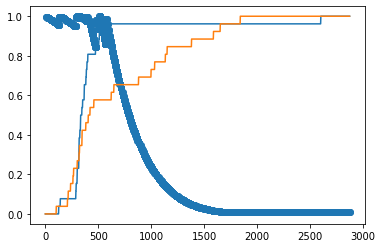

In [83]:
fig, ax = plt.subplots()
for i, (name, group) in enumerate(table.to_pandas().groupby('run_id', observed=False)):
    break
ax.plot(group['screened_order'], group['relevant'].cumsum()/group['relevant'].sum(),color='C0')
ax.plot(llm_df['order'], llm_df['recall'], color='C1')
ax.scatter(group['screened_order'], group['p_0.8'])

In [70]:
group

,rec_id,screened_order,relevant,first_prediction,last_prediction,p_0.8,p_0.9,p_0.95,p_0.99,review_id,run_id
0,https://openalex.org/W2395724835,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,https://openalex.org/W1587082112,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,https://openalex.org/W2100747541,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,https://openalex.org/W2007957200,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,https://openalex.org/W2111913459,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5741,https://openalex.org/W1542623053,2869.0,0,0.009217,0.000712,0.009805,0.009712,0.009525,0.011241,0,1
5742,https://openalex.org/W68195687,2870.0,0,0.007832,0.000618,0.009805,0.009712,0.009525,0.002600,0,1
5743,https://openalex.org/W2772518344,2871.0,0,0.008836,0.000578,0.009805,0.009712,0.009525,0.002600,0,1
5744,https://openalex.org/W2026079831,2872.0,0,0.008786,0.000521,0.009805,0.009712,0.009525,0.002600,0,1


In [51]:
table.shape

(9756, 11)

In [52]:
llm_df.shape

(4280, 16)

In [41]:
table

,rec_id,screened_order,relevant,first_prediction,last_prediction,p_0.8,p_0.9,p_0.95,p_0.99,review_id,run_id
0,https://openalex.org/W2062921950,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,https://openalex.org/W2062921950,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,https://openalex.org/W1976223226,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,https://openalex.org/W1976223226,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,https://openalex.org/W2104192390,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9751,https://openalex.org/W1561575528,4876.0,0,0.000667,0.000127,0.009906,0.009393,0.009437,0.009437,1,1
9752,https://openalex.org/W2173248159,4877.0,0,0.000553,0.000114,0.025851,0.087499,0.295922,0.295922,1,1
9753,https://openalex.org/W2173248159,4877.0,0,0.000553,0.000114,0.009906,0.009393,0.009437,0.009437,1,1
9754,https://openalex.org/W2000109650,4878.0,0,0.000541,0.000105,0.009906,0.009393,0.009437,0.009437,1,1


In [121]:
for r in [0.8,0.9,0.95,0.99]:
    for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
        s_point = llm_df.loc[llm_df[f'p_{r}']<1-c,]
        sres = {
            'recall_target': r,
            'confidence': c,
        }
        sres[f'recall'] = s_point['recall'].values[0]
        sres[f'wss'] = group.shape[0] - s_point['screened_order'].values[0]
        sres['wss_p'] = sres['wss'] / group.shape[0]

,y,py,pn,pred,screened_order,p_0.8,p_0.9,p_0.95,p_0.99,review,model,pmass,alt_pred,recall,order,x
openalex_id,,,,,,,,,,,,,,,,
https://openalex.org/W2048028478,0,0.999454,0.000016,0.999438,10,0.996519,0.996519,0.996519,0.996519,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999470,0.998908,0.0,0,0.000000
https://openalex.org/W2111623550,0,0.999440,0.000009,0.999432,11,0.996519,0.996519,0.996519,0.996519,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999449,0.998881,0.0,1,0.000349
https://openalex.org/W2583907939,0,0.999441,0.000013,0.999429,12,0.996519,0.996519,0.996519,0.996519,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999454,0.998883,0.0,2,0.000699
https://openalex.org/W2419044184,0,0.999445,0.000025,0.999420,13,0.996519,0.996519,0.996519,0.996519,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999470,0.998891,0.0,3,0.001048
https://openalex.org/W1958898999,0,0.999440,0.000021,0.999419,14,0.996519,0.996519,0.996519,0.996519,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999461,0.998880,0.0,4,0.001397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://openalex.org/W2058864990,0,0.000062,0.999716,-0.999654,2868,0.009616,0.009983,0.009874,0.012597,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999778,-0.999431,1.0,2858,0.998254
https://openalex.org/W2139864557,0,0.000008,0.999717,-0.999709,2869,0.009616,0.009983,0.009874,0.012597,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999725,-0.999434,1.0,2859,0.998603
https://openalex.org/W4301242153,0,0.000014,0.999730,-0.999716,2870,0.009616,0.009983,0.009874,0.002907,Appenzeller-Herzog_2019,meta-llama/Llama-2-70b-chat-hf,0.999745,-0.999461,1.0,2860,0.998952


In [104]:
group

stopping_points = []

for r in [0.8,0.9,0.95,0.99]:
    for c in [0.5,0.66,0.8,0.9,0.95,0.99]:
        sres = {
            'recall_target': r,
            'confidence': c,
        }
        s_point = group.loc[group[f'p_{r}']<1-c,]
        sres[f'recall'] = s_point['recall'].values[0]
        sres[f'wss'] = group.shape[0] - s_point['screened_order'].values[0]
        sres['wss_p'] = sres['wss'] / group.shape[0]
        stopping_points.append(sres)
pd.DataFrame.from_dict(stopping_points)

,recall_target,confidence,recall,wss,wss_p
0,0.80,0.50,0.961538,2113.0,0.735468
1,0.80,0.66,0.961538,1993.0,0.693700
2,0.80,0.80,0.961538,1853.0,0.644970
3,0.80,0.90,0.961538,1673.0,0.582318
4,0.80,0.95,0.961538,1513.0,0.526627
5,0.80,0.99,0.961538,1203.0,0.418726
6,0.90,0.50,0.961538,1843.0,0.641490
7,0.90,0.66,0.961538,1623.0,0.564915
8,0.90,0.80,0.961538,1363.0,0.474417
9,0.90,0.90,0.961538,1083.0,0.376958


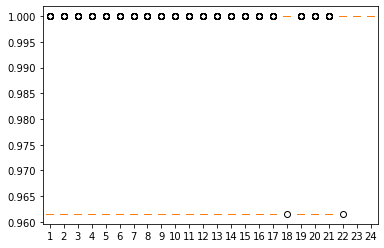

In [126]:
sdf = pd.DataFrame.from_dict(stopping_points)
recalls = []
wss_ps = []
fig, ax = plt.subplots()
for name, group in sdf.groupby(['recall_target','confidence']):
    recalls.append(group['recall'])
    wss_ps.append(group['wss_p'])
    
ax.boxplot(recalls)
plt.show()

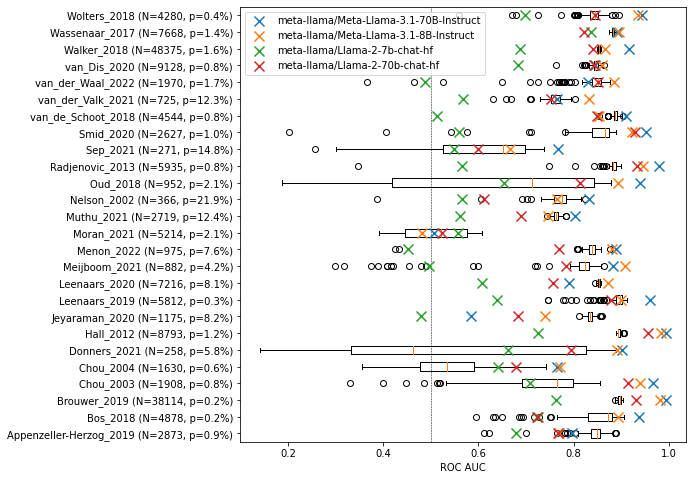

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

ax.boxplot(svm_auc_scores, vert=False)
#llm_auc_scores
ax.set_yticklabels(reviews)
for i, m in enumerate(models):
    scores = [x[i] for x in llm_auc_scores]
    ax.scatter(
        scores, 
        np.arange(len(scores))+1,
        marker='x',
        s=100,
        zorder=50,
        label=m
    )

ax.legend()
ax.axvline(0.5, lw=0.5, ls='--', color='black')
ax.set_xlabel('ROC AUC')
plt.savefig('figures/llm_svm_roc.pdf', bbox_inches='tight')
plt.show()

In [72]:
from buscarpy import retrospective_h0
batch_size=1000
model = 'meta-llama/Llama-2-7b-chat-hf'
review_name = 'Wolters_2018'
filters = [('review', '=', review_name),('model', '=', model)]
llm_df = pq.read_table(f'output_data/llm_preds',filters=filters).to_pandas().dropna()
llm_df = llm_df[pd.notnull(llm_res.index)]
llm_df['pred'] = llm_df['py'] - llm_df['pn']
llm_df = llm_df.sort_values('pred', ascending=False).reset_index()
llm_df['screened_order'] = np.arange(llm_df.shape[0])
for recall_target in [0.8,0.9,0.95,0.99]:
    pdf = pd.DataFrame(
        retrospective_h0(
            llm_df['y'], llm_df.shape[0], 
            batch_size=batch_size, plot=False, recall_target=recall_target,
            confidence_level=0.99
        )
    ).rename(columns={'p': f'p_{recall_target}'})
    llm_df = llm_df.merge(
        pdf, left_on='screened_order', right_on='batch_sizes', how='left',
    ).drop(columns='batch_sizes').ffill()
    break
llm_df = llm_df.set_index('openalex_id')
llm_df

,y,py,pn,review,model,pred,screened_order,p_0.8
openalex_id,,,,,,,,
https://openalex.org/W2042870589,0,0.999987,2.085297e-07,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999987,0,NaN
https://openalex.org/W1980799691,0,0.999981,2.307697e-07,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999980,1,NaN
https://openalex.org/W1976726807,0,0.999979,9.109093e-08,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999978,2,NaN
https://openalex.org/W2049909558,0,0.999976,2.400003e-07,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999976,3,NaN
https://openalex.org/W2079976120,0,0.999975,6.162410e-08,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,0.999975,4,NaN
...,...,...,...,...,...,...,...,...
https://openalex.org/W1702627033,0,0.001001,9.988042e-01,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,-0.997804,4275,0.000396
https://openalex.org/W2022743307,0,0.000721,9.989385e-01,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,-0.998218,4276,0.000396
https://openalex.org/W2366959778,0,0.000495,9.989610e-01,Wolters_2018,meta-llama/Llama-2-7b-chat-hf,-0.998466,4277,0.000396


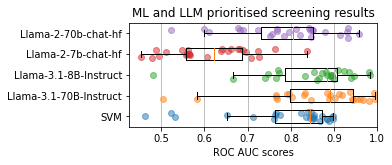

In [10]:
scaler = 1.5
fig, ax = plt.subplots(figsize=(3.7*scaler,1.6*scaler))
meds = [np.median(x) for x in svm_auc_scores]
valid_llm_auc_scores = [[y for y in x if y is not None] for x in np.array(llm_auc_scores).T]
ax.boxplot(
    [meds] + valid_llm_auc_scores,
    vert=False, widths=0.6, showfliers=False,
)
noise = (np.random.random(size=len(meds))-.5)/2
ax.scatter(
    meds, 1+noise,
    alpha=0.5
)

for i, scores in enumerate(valid_llm_auc_scores):
    noise = (np.random.random(size=len(scores))-.5)/2
    ax.scatter(
        scores, 2+i+noise,
        alpha=0.5
    )
    
model_names = [x.split('/')[1].replace('Meta-','') for x in models]
ax.set_yticklabels(['SVM']+model_names)

ax.set_xlabel('ROC AUC scores')
ax.set_title('ML and LLM prioritised screening results')
ax.grid(axis='x')
ax.set_xlim(xmax=1)

fig.tight_layout()
    
plt.savefig('figures/macro_comparison.pdf', bbox_inches='tight')

In [11]:
model = models[1]
review_name = 'Brouwer_2019'
llm_df = pq.read_table(
    f'output_data/llm_preds',
    filters=[
        ('review', '=', review_name),
        ('model', '=', model)
    ]
).to_pandas()
llm_df = proc_llm_df(llm_df)
llm_df

,y,py,pn,review,model,pred,pmass,alt_pred,recall,order,x
openalex_id,,,,,,,,,,,
https://openalex.org/W2535323633,1,0.996989,0.000662,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.996327,0.997650,0.993986,0.016129,0,0.000000
https://openalex.org/W2032916808,0,0.995154,0.001351,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993803,0.996505,0.990330,0.016129,1,0.000026
https://openalex.org/W2613037413,0,0.994973,0.001435,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993538,0.996408,0.989969,0.016129,2,0.000052
https://openalex.org/W2896320919,0,0.995438,0.001995,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993443,0.997433,0.990893,0.016129,3,0.000079
https://openalex.org/W2738442045,0,0.994463,0.001740,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.992723,0.996203,0.988954,0.016129,4,0.000105
...,...,...,...,...,...,...,...,...,...,...,...
https://openalex.org/W1569802529,0,0.000272,0.997859,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997587,0.998131,-0.995722,1.000000,38109,0.999869
https://openalex.org/W1577452758,0,0.000332,0.998106,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997774,0.998437,-0.996215,1.000000,38110,0.999895
https://openalex.org/W1996690535,0,0.000245,0.998051,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997806,0.998296,-0.996105,1.000000,38111,0.999921


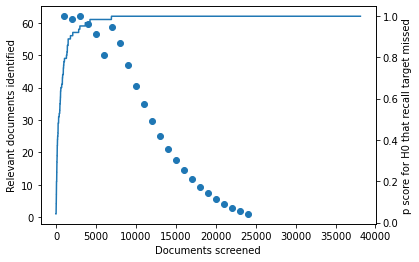

In [12]:
from buscarpy import retrospective_h0

y = llm_df.sort_values('py', ascending=False).reset_index(drop=True).y
h0 = retrospective_h0(y, llm_df.shape[0])

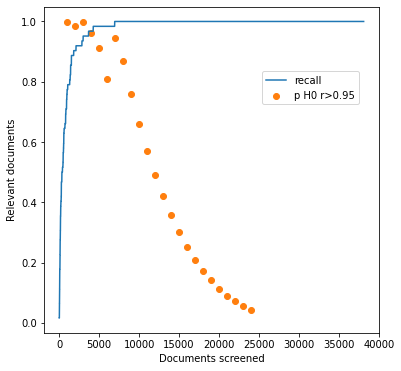

In [13]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(y.cumsum()/y.sum(), label='recall')

ax.set_ylabel('Relevant documents')



ax.scatter(h0['batch_sizes'], h0['p'], c='C1', label='p H0 r>0.95')

ax.legend(loc=(0.65,0.7))

ax.set_xlabel('Documents screened')

plt.savefig('figures/stopping.pdf', bbox_inches='tight')